<a href="https://colab.research.google.com/github/tibebu-sime/sales-predictions/blob/main/salespredictions_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


In [3]:
filename = '/content/drive/MyDrive/CodingDojo/Week2_PandasforDataManipulation/Exercises_and_Homework/sales_predictions.csv'
sales_data = pd.read_csv(filename)
sales_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
sales_data.info()

In [ ]:
#Method 2: Check and detect the presence of missing values using the isnull() function
sales_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Based on the concise summary of the dataset, there are missing values within two columns, namely Item_Weight and Outlet_Size. I will be filling the missing values within the Item_Weight column by the mean of this same column but imputing the missing values within the Outlet_Size column using the Most Freuquent Imputation technique which works well with both strings or categorical features and numerical representations.  

References: 
1. https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
2. https://jamesrledoux.com/code/imputation
3. https://stackoverflow.com/questions/32617811/imputation-of-missing-values-for-categories-in-pandas

In [ ]:
# Fill the null values within the Item_Weight column with the mean of this column
sales_data['Item_Weight'] = sales_data['Item_Weight'].fillna(sales_data['Item_Weight'].mean())
sales_data.head()

In [ ]:
# Check and detect the presence of missing values using the isnull() function again
sales_data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') # the data is converted into NumPy array
sales_data = pd.DataFrame(imputer.fit_transform(sales_data), index=sales_data.index, columns=sales_data.columns)
sales_data.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.0160473,Dairy,249.809,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14
1,DRC01,5.92,Regular,0.0192782,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.423
2,FDN15,17.5,Low Fat,0.0167601,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.2,Regular,0,Fruits and Vegetables,182.095,OUT010,1998,Medium,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.705


In [ ]:
# Check and detect the presence of missing values using the isnull() function again
sales_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
# Displaying the descriptive statistics of the dataframe 
sales_data.describe()

In [ ]:
# Checking the unique appearances of each column in the dataset and replace the 
# inconsistencies 
sales_data.apply(lambda x: x.unique())

In [ ]:
# There are data entry inconsistencies in the Item_Fat_Content, so I need to
# replace them. 
sales_data['Item_Fat_Content'].unique()

In [6]:
sales_data['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}, inplace=True)

In [ ]:
sales_data['Item_Fat_Content'].unique()

#Data Visualization 

In [9]:
# Changing the data types of the columns whose data types have been modified when
# the missing values in the Outlet_Size column were imputed. 
# Reference: https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

sales_data = sales_data.astype({'Item_Weight': float, 
                                'Item_Visibility': float,
                                'Item_MRP': float,
                                'Outlet_Establishment_Year': int,
                                'Item_Outlet_Sales': float
                                               })

In [10]:
# Checking the data types 
sales_data.dtypes 

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [11]:
# the average item sales by the location types of the store 
sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean()

Outlet_Location_Type
Tier 1    1876.909159
Tier 2    2323.990559
Tier 3    2279.627651
Name: Item_Outlet_Sales, dtype: float64

In [12]:
# the average item sales by the types of store 
sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()

Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

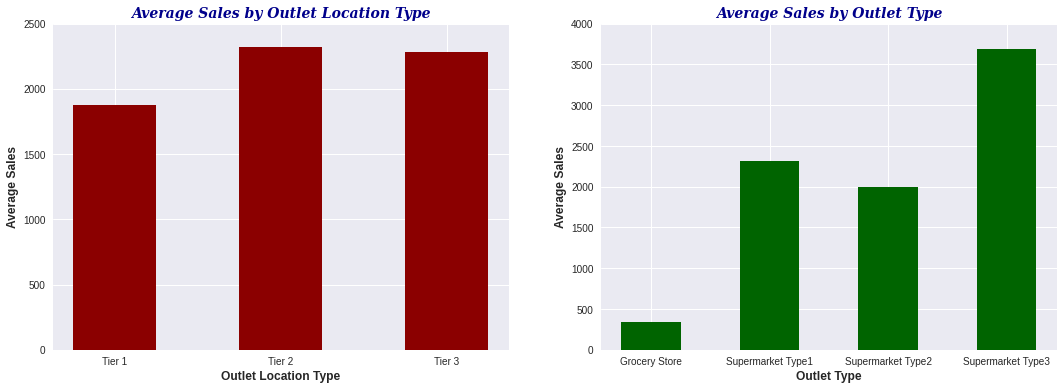

In [13]:
x0 = sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().index
y0 = sales_data.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().values

x1 = sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().index
y1 = sales_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().values

plt.style.use('seaborn')

font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
axs[0].bar(x0, y0, width=0.5, color='darkred')
axs[0].set_title('Average Sales by Outlet Location Type', fontdict=font)
axs[0].set_ylim(0, 2500)
#Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tick_params.html
axs[0].tick_params(axis='both', labelsize=10)  
axs[0].set_xlabel('Outlet Location Type', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Average Sales', fontsize=12, fontweight='bold')

axs[1].bar(x1, y1, width=0.5, color='darkgreen')
axs[1].set_title('Average Sales by Outlet Type', fontdict=font)
axs[1].set_ylim(0, 4000)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_xlabel('Outlet Type', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Average Sales', fontsize=12, fontweight='bold')

plt.show()

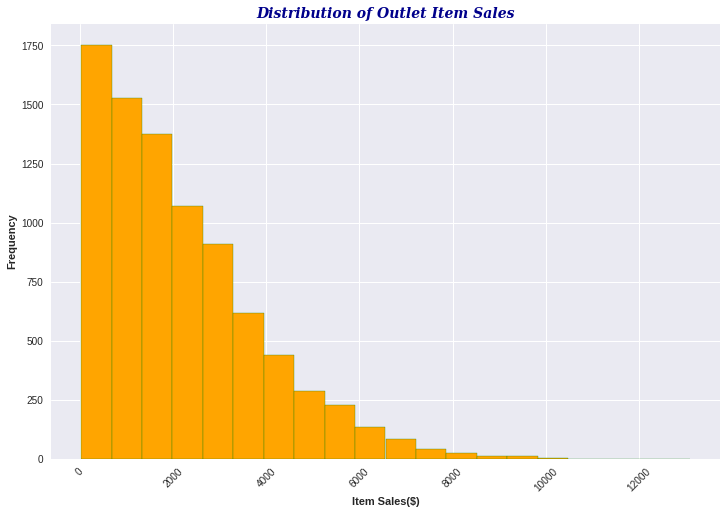

In [14]:
# Visualize the distribution of the item sales 
sales_data['Item_Outlet_Sales'].hist(bins=20, color='orange', edgecolor='green', figsize=(12, 8))
plt.xticks(rotation=45)
plt.ticklabel_format(useOffset=False, style='plain')

font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }

plt.xlabel('Item Sales($)', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Distribution of Outlet Item Sales', fontdict=font)
plt.show()

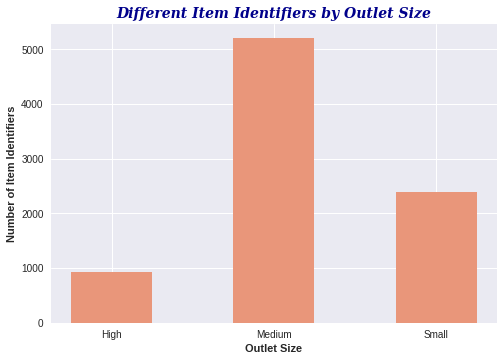

In [ ]:
# Number of different item identifiers by the store size
# References: 1. https://pythonbasics.org/matplotlib-bar-chart/
#             2. https://www.geeksforgeeks.org/plotting-multiple-bar-charts-using-matplotlib-in-python/
#             3. https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

sales_data.groupby('Outlet_Size')['Item_Identifier'].count()
x = sales_data.groupby('Outlet_Size')['Item_Identifier'].count().index
y = sales_data.groupby('Outlet_Size')['Item_Identifier'].count().values
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }
plt.bar(x, y, color='darksalmon', width=0.5)
plt.title('Different Item Identifiers by Outlet Size', fontdict=font)
plt.xlabel('Outlet Size', fontweight='bold')
plt.ylabel('Number of Item Identifiers', fontweight='bold')
plt.show()


In [ ]:
# Check different types items available in the whole store 
# Help from: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.value_counts.html

sales_data.value_counts(subset='Item_Identifier')

In [ ]:
#Method 2 - the relative frequency of each unique item
sales_data['Item_Identifier'].value_counts()
sales_data['Item_Identifier'].value_counts(normalize=True)

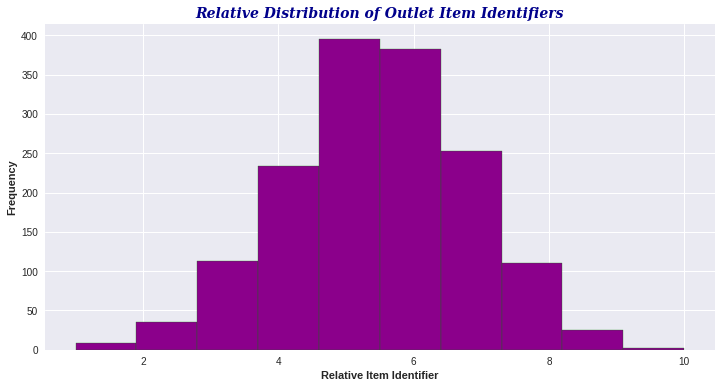

In [17]:
sales_data['Item_Identifier'].value_counts().hist(color='darkmagenta', edgecolor='g', figsize=(12, 6))
font = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 14,
        'fontweight': 'bold',
        'color': 'DarkBlue'
        }
plt.title('Relative Distribution of Outlet Item Identifiers', fontdict=font)
plt.xlabel('Relative Item Identifier', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

In [ ]:
# Different varieties of fats in food items by the Outlet Type
# Reference: https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/
sales_data.groupby('Outlet_Size')['Item_Fat_Content'].value_counts()



Outlet_Size  Item_Fat_Content
High         Low Fat              606
             Regular              326
Medium       Low Fat             3361
             Regular             1842
Small        Low Fat             1550
             Regular              838
Name: Item_Fat_Content, dtype: int64

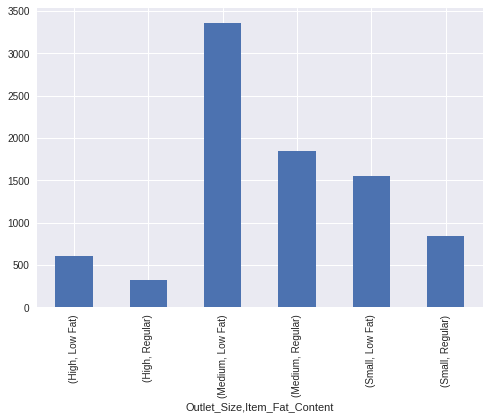

In [25]:
sales_data.groupby('Outlet_Size')['Item_Fat_Content'].value_counts().plot.bar()
plt.show()


In [18]:
# Plotting the correlation between features using heatmaps 
correlation = sales_data.corr()

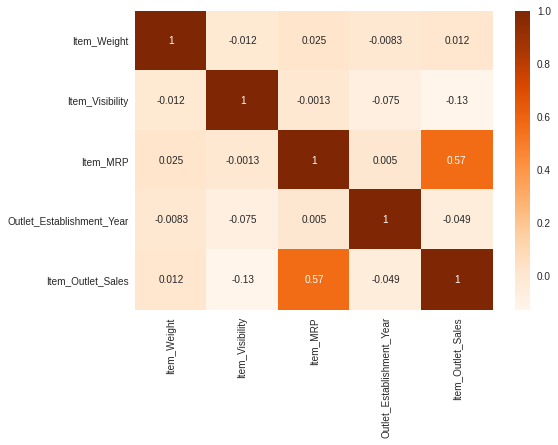

In [24]:
sns.heatmap(correlation, cmap='Oranges', annot=True)
plt.show()

From the above heatmap, there is a moderate positive relationship between the Item MRP and Item Outlet Sales as the correlation coefficient is equal to 0.57.

#Boxplot
Graph boxplots to show the distribution of the continuous Item Outlet Sales feature for the different types of Outlet Location.

In [ ]:
tier1 = sales_data['Outlet_Location_Type'] == 'Tier 1'
sales_data[tier1]

In [ ]:
tier2 = sales_data['Outlet_Location_Type'] == 'Tier 2'
sales_data[tier2]

In [ ]:
tier3 = sales_data['Outlet_Location_Type'] == 'Tier 3'
sales_data[tier3]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


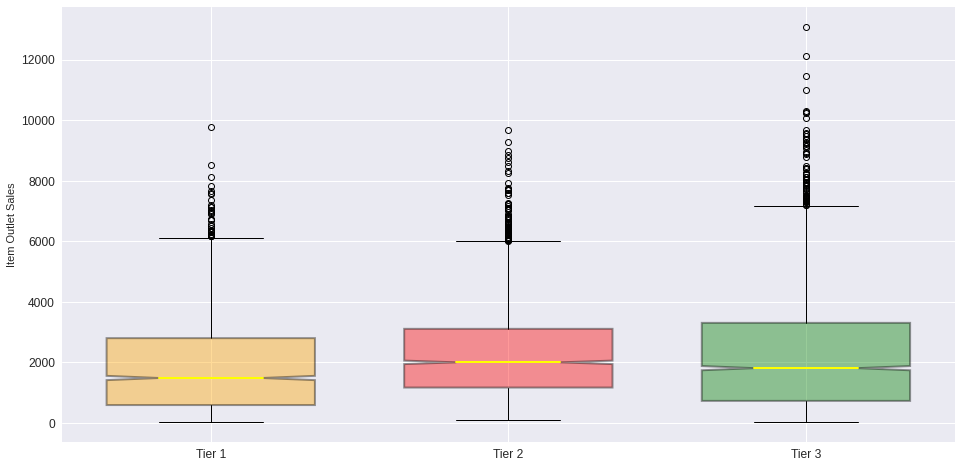

In [50]:
x1 = sales_data[tier1]['Item_Outlet_Sales'].values
x2 = sales_data[tier2]['Item_Outlet_Sales'].values
x3 = sales_data[tier3]['Item_Outlet_Sales'].values

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
boxplots = ax.boxplot([x1, x2, x3], 
           labels=['Tier 1', 'Tier 2', 'Tier 3'], 
           notch =True,
           widths = 0.7,
           patch_artist =True,
           medianprops = dict(linestyle ='-', linewidth=2, color='yellow'),
           boxprops = dict(linestyle ='--', linewidth=2, color='black', facecolor='blue', alpha=0.4)
           )

boxplot1 = boxplots['boxes'][0]
boxplot2 = boxplots['boxes'][1]
boxplot3 = boxplots['boxes'][2]
boxplot1.set_facecolor('orange')
boxplot2.set_facecolor('red')
boxplot3.set_facecolor('green')


ax.set_ylabel('Item Outlet Sales')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()